<a href="https://colab.research.google.com/github/Deadsong02/EntregaProyecto/blob/main/Proyecto2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd

# Ruta de la carpeta que contiene los archivos de datos
ruta_carpeta = '/content/DatasetProyecto/'

# Lista para almacenar los DataFrames de cada archivo
dataframes = []

# Recorremos cada archivo en la carpeta
for archivo in os.listdir(ruta_carpeta):
    if archivo.endswith('.csv'):
        # Cargamos el archivo CSV en un DataFrame sin especificar nombres de columnas
        ruta_archivo = os.path.join(ruta_carpeta, archivo)
        print("Leyendo archivo:", archivo)  # Imprimir el nombre del archivo que se está leyendo
        df = pd.read_csv(ruta_archivo, sep=';', header=None)

        # Asignamos nombres a las columnas
        df.columns = ['ID nodo', 'Fecha', 'Consumo', 'Flag de calidad', 'Número de muestras', 'Subestacion']

        # Eliminamos las columnas 'ID nodo', 'Flag de calidad' y 'Número de muestras'
        df.drop(columns=['ID nodo', 'Flag de calidad', 'Número de muestras'], inplace=True)

        # Convertir la columna de fecha y hora a un objeto de fecha y hora
        df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')

        # Extraer solo la primera palabra antes del espacio en la columna "Subestacion"
        df['Subestacion'] = df['Subestacion'].str.split().str[0]

        # Añadimos el DataFrame a la lista
        dataframes.append(df)

# Combinamos todos los DataFrames en uno único
dataset_final = pd.concat(dataframes)

# Ordenamos el conjunto de datos por fecha y hora (asegurándonos de que esté ordenado)
dataset_final = dataset_final.sort_values(by='Fecha')

# Mostrar las primeras filas del conjunto de datos final
print("Primeras filas del conjunto de datos final:")
print(dataset_final.head())

# Mostrar las últimas filas del conjunto de datos final
print("\nÚltimas filas del conjunto de datos final:")
print(dataset_final.tail())


# Guardamos el conjunto de datos final en un archivo CSV
dataset_final.to_csv('/content/Resultados/dataset_final.csv', index=False)


Leyendo archivo: T28052_CNANCUAN_NM10_202301.csv
Leyendo archivo: T28052_CNANCUAN_NM66_202110.csv
Leyendo archivo: T28052_CNANCUAN_NM66_202010.csv
Leyendo archivo: T28052_CNANCUAN_NM66_201903.csv
Leyendo archivo: T28052_CNANCUAN_NM66_201808.csv
Leyendo archivo: T28052_CNANCUAN_NM66_202012.csv
Leyendo archivo: T28052_CNANCUAN_NM66_201705.csv
Leyendo archivo: T28052_CNANCUAN_NM66_201706.csv
Leyendo archivo: T28052_CNANCUAN_NM66_201902.csv
Leyendo archivo: T28052_CNANCUAN_NM66_201804.csv
Leyendo archivo: T28052_CNANCUAN_NM66_201810.csv
Leyendo archivo: T28052_CNANCUAN_NM66_202101.csv
Leyendo archivo: T28052_CNANCUAN_NM66_202007.csv
Leyendo archivo: T28052_CNANCUAN_NM66_202001.csv
Leyendo archivo: T28052_CNANCUAN_NM66_201712.csv
Leyendo archivo: T28052_CNANCUAN_NM10_202207.csv
Leyendo archivo: T28052_CNANCUAN_NM66_201806.csv
Leyendo archivo: T28052_CNANCUAN_NM66_202103.csv
Leyendo archivo: T28052_CNANCUAN_NM66_201708.csv
Leyendo archivo: T28052_CNANCUAN_NM66_201702.csv
Leyendo archivo: T28

In [ ]:
import os
import pandas as pd

# Ruta del archivo CSV
ruta_archivo = '/content/Resultados/dataset_final.csv'

# Cargar los datos en un DataFrame
dataset = pd.read_csv(ruta_archivo)
dataset["Fecha"]=pd.to_datetime(dataset["Fecha"],format="%Y-%m-%d %H:%M:%S")
dataset.info()
# Visualizar las primeras filas del DataFrame
print(dataset.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2242968 entries, 0 to 2242967
Data columns (total 3 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Fecha        object 
 1   Consumo      float64
 2   Subestacion  object 
dtypes: float64(1), object(2)
memory usage: 51.3+ MB
                       Fecha     Consumo Subestacion
0  2017-02-28 15:00:00-03:00  -37.201006     FLORIDA
1  2017-02-28 15:00:00-03:00   69.646437     FLORIDA
2  2017-02-28 15:00:00-03:00  116.025003     AJAHUEL
3  2017-02-28 15:00:00-03:00  120.118144     AJAHUEL
4  2017-02-28 15:00:00-03:00  -32.904251      CNAVIA


In [ ]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Convertir la columna 'Fecha' a formato de fecha y hora
dataset['Fecha'] = pd.to_datetime(dataset['Fecha'], utc=True)

# Filtrar los datos para el rango de años deseado y establecer el índice
train = dataset[(dataset['Fecha'].dt.year > 2017) & (dataset['Fecha'].dt.year < 2022)]
train = train.set_index("Fecha")


In [ ]:
# Seleccionar solo las filas del DataFrame 'dataset' donde el año en la columna 'Fecha' es igual a 2022
test = dataset.query("Fecha.dt.year == 2022")

# Establecer la columna 'Fecha' como el índice del DataFrame resultante 'test'
test = test.set_index("Fecha")


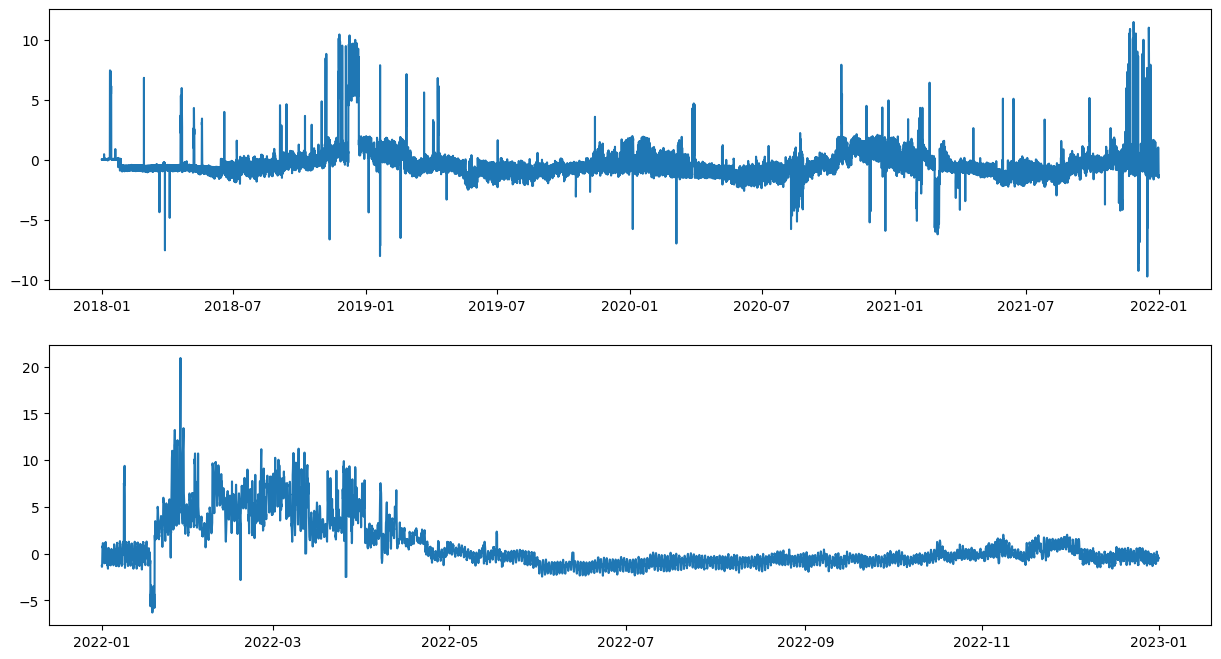

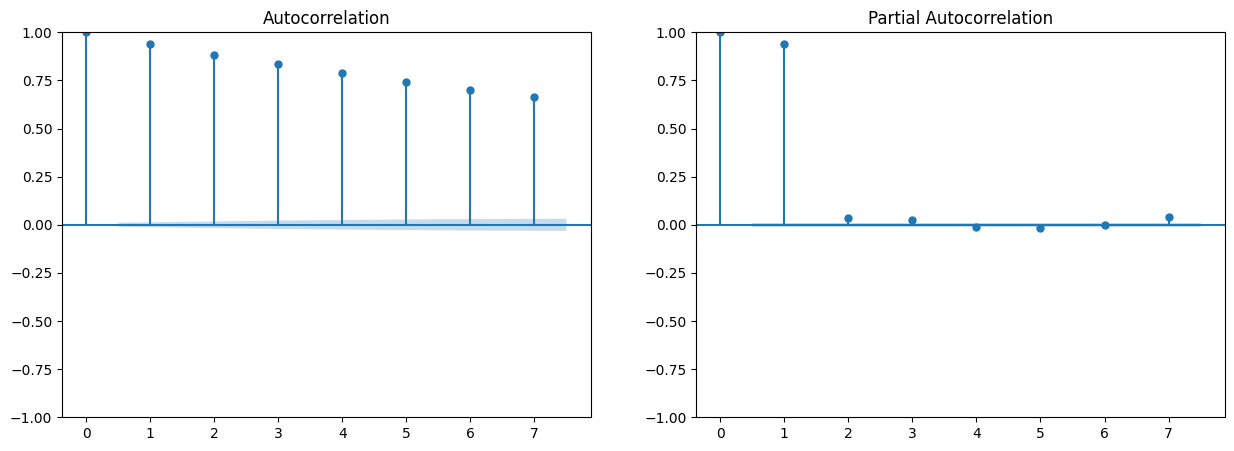

In [ ]:
# Seleccionar la subestación de interés
subestacion = "FLORIDA"

# Crear un filtro basado en la subestación seleccionada
filtro = "Subestacion=='{0}'".format(subestacion)

# Filtrar los datos de entrenamiento para obtener el consumo promedio por fecha para la subestación seleccionada
ds_train = train.query(filtro)["Consumo"].groupby("Fecha").aggregate(Consumo="mean")

# Convertir los datos de consumo promedio a un arreglo NumPy para el eje y del gráfico
ym = ds_train["Consumo"].to_numpy()

# Convertir las fechas a un arreglo NumPy para el eje x del gráfico
xm = ds_train.index.to_numpy()

# Filtrar los datos de prueba para obtener el consumo promedio por fecha para la subestación seleccionada
ds_test = test.query(filtro)["Consumo"].groupby("Fecha").aggregate(Consumo="mean")

# Convertir los datos de consumo promedio de prueba a un arreglo NumPy para el eje y del segundo gráfico
ytm = ds_test["Consumo"].to_numpy()

# Convertir las fechas de prueba a un arreglo NumPy para el eje x del segundo gráfico
xtm = ds_test.index.to_numpy()

# Crear una figura con dos subgráficos para visualizar los datos de entrenamiento y prueba
fig, axes = plt.subplots(2, 1)
fig.set_size_inches(15, 8)

# Graficar los datos de consumo promedio de entrenamiento
axes[0].plot(xm, ym)

# Graficar los datos de consumo promedio de prueba
axes[1].plot(xtm, ytm)

# Crear otra figura con dos subgráficos para visualizar la función de autocorrelación y autocorrelación parcial
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

# Graficar la función de autocorrelación para los datos de entrenamiento
plot_acf(ym, lags=7, ax=axes[0])

# Graficar la función de autocorrelación parcial para los datos de entrenamiento
plot_pacf(ym, lags=7, method="ywm", ax=axes[1])


In [ ]:
import datetime

# Definir el número de horas entre las fechas de inicio y fin
deltas = 365 * 24 * 4

# Agregar un día al rango debido al año bisiesto 2020
deltas += 24

# Definir la fecha de inicio del conjunto de entrenamiento
start = datetime.datetime.strptime("2018-01-01 00:00:00", '%Y-%m-%d %H:%M:%S')

# Crear una lista de fechas que representan el conjunto de entrenamiento completo
train_full = [start + datetime.timedelta(hours=x) for x in range(deltas)]

# Definir el número de horas entre las fechas de inicio y fin para el conjunto de prueba
deltas = 365 * 24

# Definir la fecha de inicio del conjunto de prueba
start = datetime.datetime.strptime("2022-01-01 00:00:00", '%Y-%m-%d %H:%M:%S')

# Crear una lista de fechas que representan el conjunto de prueba completo
test_full = [start + datetime.timedelta(hours=x) for x in range(deltas)]

# Inicializar listas para almacenar las fechas faltantes en el conjunto de entrenamiento y prueba
missing_train = []
missing_test = []

# Verificar las fechas faltantes en el conjunto de entrenamiento
for fecha in train_full:
    if not (fecha in ds_train.index):
        missing_train.append(fecha)

# Verificar las fechas faltantes en el conjunto de prueba
for fecha in test_full:
    if not (fecha in ds_test.index):
        missing_test.append(fecha)

# Imprimir el número de fechas en el conjunto de entrenamiento completo, el número de fechas presentes en el conjunto de entrenamiento real y el número de fechas faltantes en el conjunto de entrenamiento
print(len(train_full), len(ds_train), len(missing_train))

# Imprimir el número de fechas en el conjunto de prueba completo, el número de fechas presentes en el conjunto de prueba real y el número de fechas faltantes en el conjunto de prueba
print(len(test_full), len(ds_test), len(missing_test))

# Imprimir las fechas faltantes en el conjunto de prueba
for missing in missing_test:
    print(missing.strftime('%Y-%m-%d %H:%M:%S'))


Se truncaron las últimas líneas 5000 del resultado de transmisión.
2022-06-06 16:00:00
2022-06-06 17:00:00
2022-06-06 18:00:00
2022-06-06 19:00:00
2022-06-06 20:00:00
2022-06-06 21:00:00
2022-06-06 22:00:00
2022-06-06 23:00:00
2022-06-07 00:00:00
2022-06-07 01:00:00
2022-06-07 02:00:00
2022-06-07 03:00:00
2022-06-07 04:00:00
2022-06-07 05:00:00
2022-06-07 06:00:00
2022-06-07 07:00:00
2022-06-07 08:00:00
2022-06-07 09:00:00
2022-06-07 10:00:00
2022-06-07 11:00:00
2022-06-07 12:00:00
2022-06-07 13:00:00
2022-06-07 14:00:00
2022-06-07 15:00:00
2022-06-07 16:00:00
2022-06-07 17:00:00
2022-06-07 18:00:00
2022-06-07 19:00:00
2022-06-07 20:00:00
2022-06-07 21:00:00
2022-06-07 22:00:00
2022-06-07 23:00:00
2022-06-08 00:00:00
2022-06-08 01:00:00
2022-06-08 02:00:00
2022-06-08 03:00:00
2022-06-08 04:00:00
2022-06-08 05:00:00
2022-06-08 06:00:00
2022-06-08 07:00:00
2022-06-08 08:00:00
2022-06-08 09:00:00
2022-06-08 10:00:00
2022-06-08 11:00:00
2022-06-08 12:00:00
2022-06-08 13:00:00
2022-06-08 14

In [ ]:
# Ordenar el DataFrame de entrenamiento por el índice (en este caso, por fecha)
ds_train.sort_index(inplace=True)

# Ordenar el DataFrame de prueba por el índice (en este caso, por fecha)
ds_test.sort_index(inplace=True)

# Guardar el DataFrame de entrenamiento ordenado en un archivo CSV llamado "entrenamiento.csv"
ds_train.to_csv("entrenamiento.csv")

# Guardar el DataFrame de prueba ordenado en un archivo CSV llamado "d_prueba.csv"
ds_test.to_csv("d_prueba.csv")


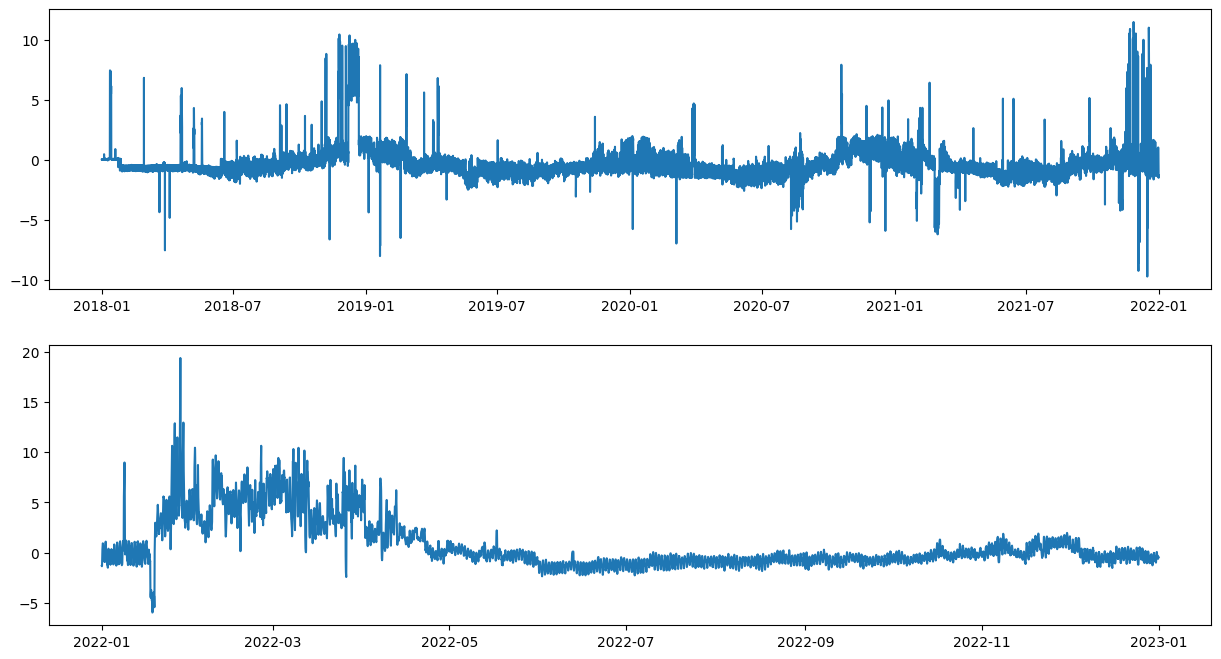

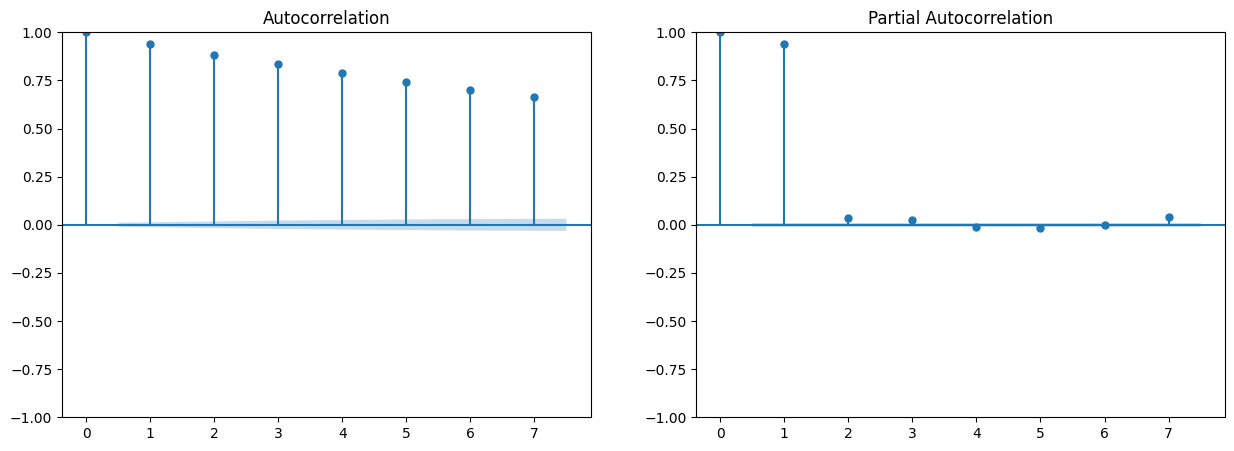

In [ ]:
# Convertir la columna "Consumo" del DataFrame de entrenamiento en un arreglo NumPy para el eje y del primer gráfico
ym = ds_train["Consumo"].to_numpy()

# Convertir los índices (fechas) del DataFrame de entrenamiento en un arreglo NumPy para el eje x del primer gráfico
xm = ds_train.index.to_numpy()

# Convertir la columna "Consumo" del DataFrame de prueba en un arreglo NumPy para el eje y del segundo gráfico
ytm = ds_test["Consumo"].to_numpy()

# Convertir los índices (fechas) del DataFrame de prueba en un arreglo NumPy para el eje x del segundo gráfico
xtm = ds_test.index.to_numpy()

# Crear una figura con dos subgráficos para visualizar los datos de entrenamiento y prueba
fig, axes = plt.subplots(2, 1)

# Establecer el tamaño de la figura
fig.set_size_inches(15, 8)

# Graficar los datos de consumo promedio de entrenamiento
axes[0].plot(xm, ym)

# Graficar los datos de consumo promedio de prueba
axes[1].plot(xtm, ytm)

# Crear otra figura con dos subgráficos para visualizar la función de autocorrelación y autocorrelación parcial
fig, axes = plt.subplots(1, 2)

# Establecer el tamaño de la segunda figura
fig.set_size_inches(15, 5)

# Graficar la función de autocorrelación para los datos de entrenamiento
plot_acf(ym, lags=7, ax=axes[0])

# Graficar la función de autocorrelación parcial para los datos de entrenamiento
plot_pacf(ym, lags=7, method="ywm", ax=axes[1])


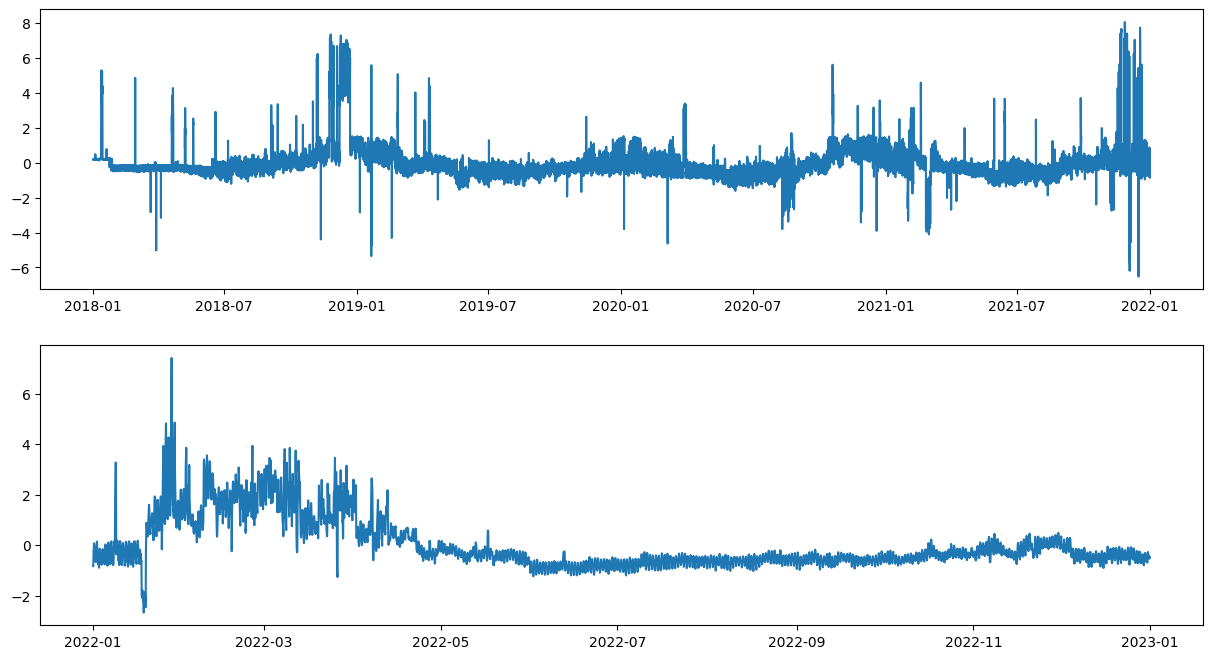

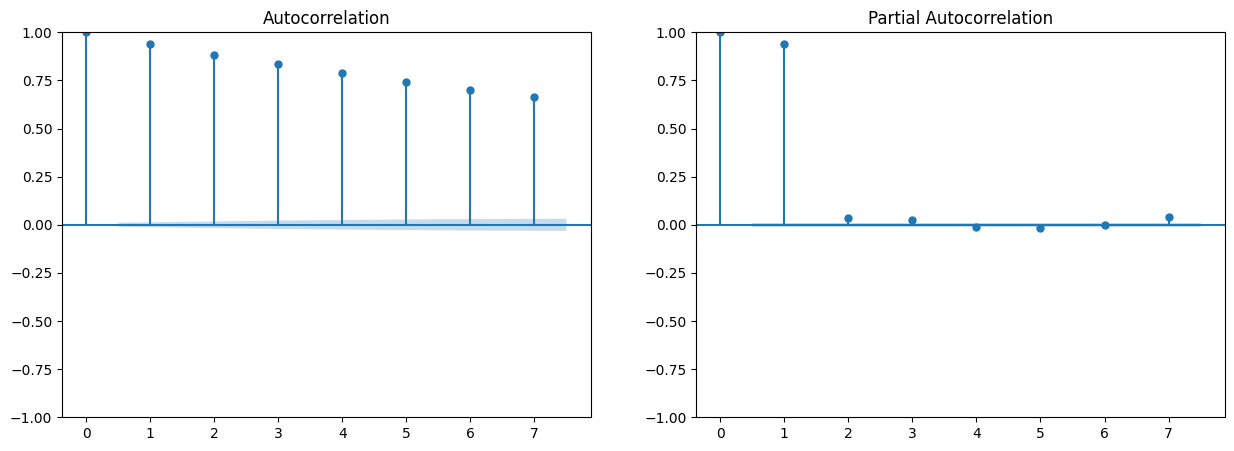

In [ ]:
# Inicializar un objeto StandardScaler para estandarizar los datos
scaler = StandardScaler()

# Reorganizar la forma del arreglo de los datos de entrenamiento para que tenga una sola característica por muestra
ym = ym.reshape(-1, 1)

# Ajustar el scaler a los datos de entrenamiento y transformarlos
scaler.fit(ym)
ym_z = scaler.transform(ym)

# Reorganizar la forma del arreglo de los datos de prueba para que tenga una sola característica por muestra
ytm = ytm.reshape(-1, 1)

# Ajustar el scaler a los datos de prueba y transformarlos
scaler.fit(ytm)
ytm_z = scaler.transform(ytm)

# Crear una figura con dos subgráficos para visualizar los datos de entrenamiento y prueba estandarizados
fig, axes = plt.subplots(2, 1)

# Establecer el tamaño de la figura
fig.set_size_inches(15, 8)

# Graficar los datos de consumo promedio de entrenamiento estandarizados
axes[0].plot(xm, ym_z)

# Graficar los datos de consumo promedio de prueba estandarizados
axes[1].plot(xtm, ytm_z)

# Crear otra figura con dos subgráficos para visualizar la función de autocorrelación y autocorrelación parcial de los datos de entrenamiento estandarizados
fig, axes = plt.subplots(1, 2)

# Establecer el tamaño de la segunda figura
fig.set_size_inches(15, 5)

# Graficar la función de autocorrelación para los datos de entrenamiento estandarizados
plot_acf(ym_z, lags=7, ax=axes[0])

# Graficar la función de autocorrelación parcial para los datos de entrenamiento estandarizados
plot_pacf(ym_z, lags=7, method="ywm", ax=axes[1])


In [ ]:
# Realizar el test de Dickey-Fuller aumentado en los datos de entrenamiento
result = adfuller(ym)

# Imprimir la estadística ADF
print('ADF Statistic: %f' % result[0])

# Imprimir el p-valor
print('p-value: %f' % result[1])

# Imprimir los valores críticos
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -10.857221
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [ ]:
# Crear un modelo ARIMA con los datos de entrenamiento y el orden especificado
modelo_florida = ARIMA(ym, order=(2, 0, 2))

# Ajustar el modelo a los datos de entrenamiento
m_ad1 = modelo_florida.fit()

# Imprimir el error cuadrático medio (MSE) del modelo ajustado
print("MSE", m_ad1.mse)

# Imprimir el criterio de información de Akaike (AIC) del modelo ajustado
print("AIC", m_ad1.aic)

# Predecir los valores de los datos de entrenamiento utilizando el modelo ajustado
ymp = m_ad1.predict()

# Predecir los valores futuros utilizando el modelo ajustado
ytmp = m_ad1.forecast(7 * 24)


MSE 0.25344991152889573
AIC 51177.321766044886


-0.2290040584206834 0.19272830365179192 -0.8415933978678559


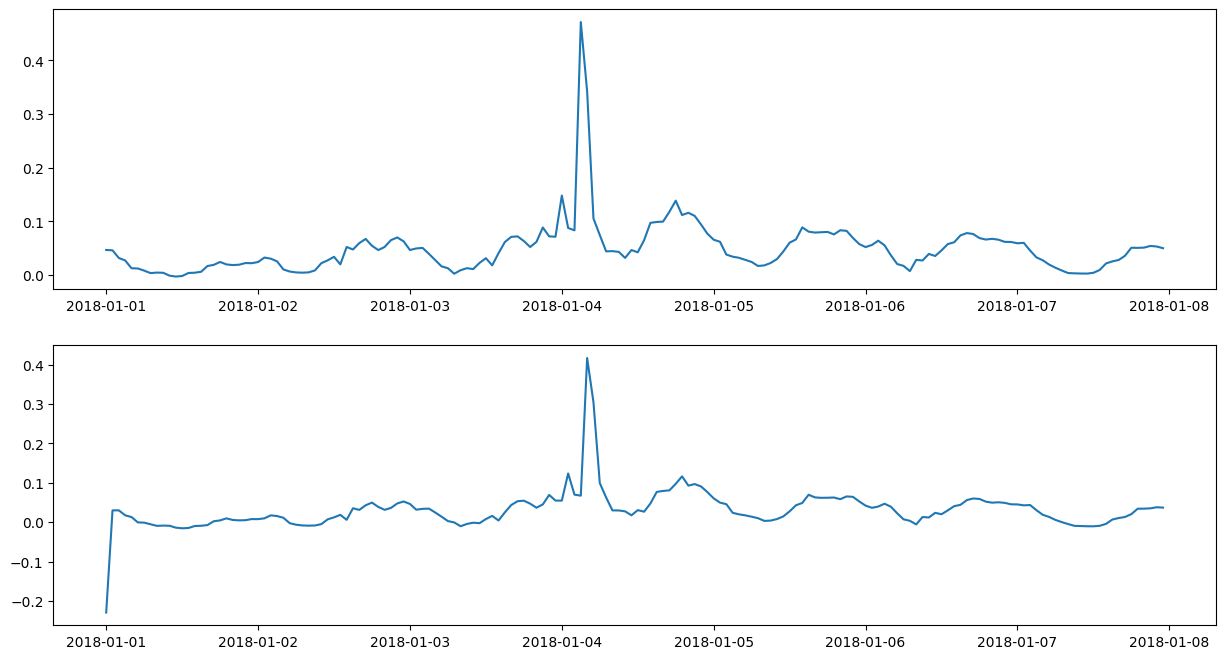

In [ ]:
# Crear una figura con dos subgráficos para visualizar los datos reales y las predicciones del modelo en un período de 7 días
fig, axes = plt.subplots(2, 1)

# Establecer el tamaño de la figura
fig.set_size_inches(15, 8)

# Graficar los datos reales de consumo promedio durante los primeros 7 días del conjunto de entrenamiento
axes[0].plot(xm[:7*24], ym[:7*24])

# Graficar las predicciones del modelo durante los primeros 7 días del conjunto de entrenamiento
axes[1].plot(xm[:7*24], ymp[:7*24])

# Calcular la media de los datos reales de consumo promedio
media = np.mean(ym)

# Calcular el error absoluto medio entre los datos reales y las predicciones del modelo
error = mean_absolute_error(ym, ymp)

# Imprimir la media, el error absoluto medio y el error relativo al valor medio
print(media, error, error/media)


-0.34405771608670377 0.6832346002846771 -1.9858139153388426


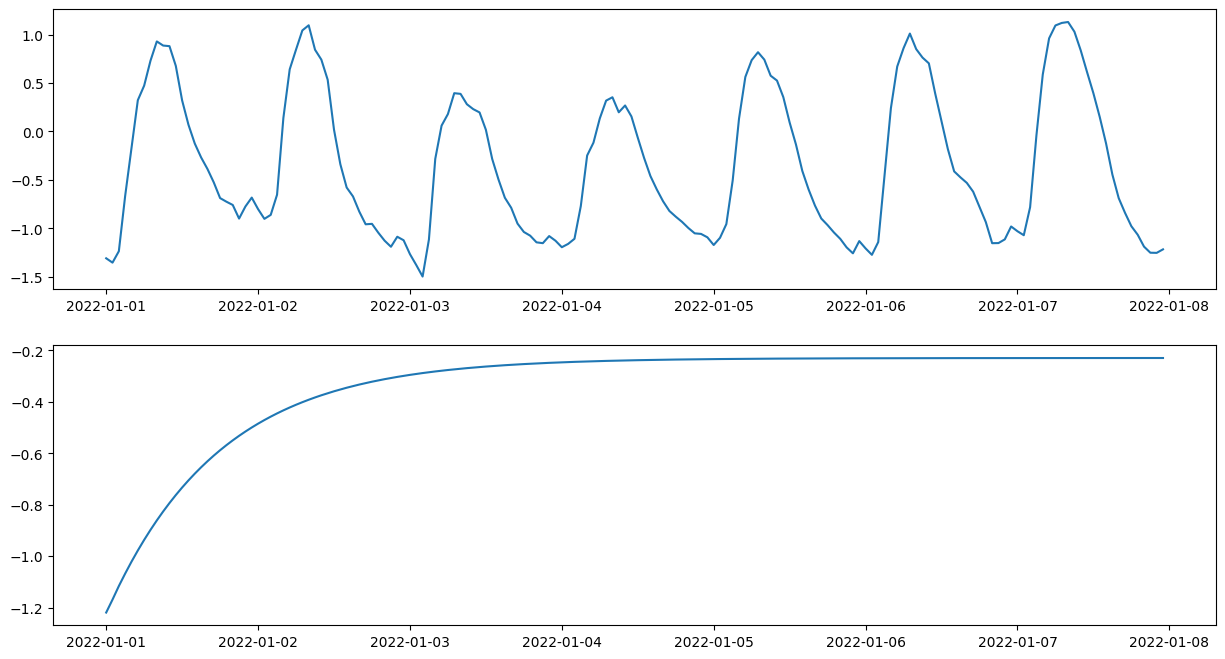

In [ ]:
# Crear una figura con dos subgráficos para visualizar los datos reales y las predicciones del modelo para los primeros 7 días del conjunto de prueba
fig, axes = plt.subplots(2, 1)

# Establecer el tamaño de la figura
fig.set_size_inches(15, 8)

# Graficar los datos reales de consumo promedio durante los primeros 7 días del conjunto de prueba
axes[0].plot(xtm[:7*24], ytm[:7*24])

# Graficar las predicciones del modelo durante los primeros 7 días del conjunto de prueba
axes[1].plot(xtm[:7*24], ytmp)

# Calcular la media de los datos reales de consumo promedio durante los primeros 7 días del conjunto de prueba
media = np.mean(ytm[:7*24])

# Calcular el error absoluto medio entre los datos reales y las predicciones del modelo para los primeros 7 días del conjunto de prueba
error = mean_absolute_error(ytm[:7*24], ytmp)

# Imprimir la media, el error absoluto medio y el error relativo al valor medio para los primeros 7 días del conjunto de prueba
print(media, error, error/media)


In [ ]:
# Listas para almacenar las secuencias de datos de entrada y salida
yw = []  # Datos de entrada (ventanas)
yt = []  # Datos de salida

# Tamaño de la ventana para crear las secuencias de entrada y salida
window = 2

# Iterar sobre los datos de entrenamiento para crear las secuencias
for i in range(0, len(ym)):
    # Verificar si todavía hay suficientes puntos de datos para crear una ventana completa
    if i + window < len(ym):
        # Crear una fila (secuencia) para la ventana actual
        row = []
        # Iterar sobre los puntos de datos dentro de la ventana
        for j in range(window):
            # Agregar el punto de datos al conjunto de datos de entrada
            row.append(ym[i + j])
        # Agregar la ventana completa al conjunto de datos de entrada
        yw.append(row)
        # Agregar el punto de datos siguiente al conjunto de datos de salida
        yt.append(ym[i + window])
    else:
        # Si no quedan suficientes puntos de datos, salir del bucle
        break

# Imprimir la cantidad de secuencias creadas
print(len(yw))

# Convertir las listas de Python a arreglos NumPy
yw = np.asarray(yw)
yt = np.asarray(yt)


34915


In [ ]:
# Listas para almacenar las secuencias de datos de entrada y salida del conjunto de prueba
yw_test = []  # Datos de entrada (ventanas)
yt_test = []  # Datos de salida

# Tamaño de la ventana para crear las secuencias de entrada y salida
window = 2

# Iterar sobre los datos de prueba para crear las secuencias
for i in range(0, len(ytm)):
    # Verificar si todavía hay suficientes puntos de datos para crear una ventana completa
    if i + window < len(ytm):
        # Crear una fila (secuencia) para la ventana actual
        row = []
        # Iterar sobre los puntos de datos dentro de la ventana
        for j in range(window):
            # Agregar el punto de datos al conjunto de datos de entrada
            row.append(ytm[i + j])
        # Agregar la ventana completa al conjunto de datos de entrada
        yw_test.append(row)
        # Agregar el punto de datos siguiente al conjunto de datos de salida
        yt_test.append(ytm[i + window])
    else:
        # Si no quedan suficientes puntos de datos, salir del bucle
        break

# Imprimir la cantidad de secuencias creadas para el conjunto de prueba
print(len(yw_test))

# Convertir las listas de Python a arreglos NumPy para el conjunto de prueba
yw_test = np.asarray(yw_test)
yt_test = np.asarray(yt_test)


8758


In [ ]:
import tensorflow as tf
from datetime import datetime
from tensorflow import keras
from keras.layers import SimpleRNN, LSTM, Input, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import random as rd

In [ ]:
# Semilla utilizada para la generación de números aleatorios
seed = 12122008

# Fijar la semilla para la generación de números aleatorios de Python
rd.seed(seed)

# Fijar la semilla para la generación de números aleatorios de NumPy
np.random.seed(seed)

# Fijar la semilla para la generación de números aleatorios de TensorFlow
tf.random.set_seed(seed)

# Crear un modelo secuencial
model = Sequential()

# Añadir una capa de entrada al modelo, especificando el nombre y la forma de los datos de entrada
model.add(Input(name="serie", shape=(2, 1)))

# Añadir una capa de red neuronal recurrente simple con 256 unidades
model.add(SimpleRNN(256))

# Añadir una capa densa con 128 unidades
model.add(Dense(128))

# Añadir una capa densa de salida con 1 unidad y activación lineal
model.add(Dense(1, activation='linear'))

# Imprimir un resumen del modelo, mostrando la arquitectura y el número de parámetros
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 256)               66048     
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 99073 (387.00 KB)
Trainable params: 99073 (387.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Generar una etiqueta única para el registro con el formato 'rnn YYYYMMDD-HHMMSS' utilizando la fecha y hora actual
tag = "rnn" + datetime.now().strftime("%Y%m%d-%H%M%S")

# Directorio de registro para TensorBoard que incluye la etiqueta única
log_dir = "logs/fit/" + tag

# Callback de TensorBoard para registrar la información del entrenamiento en el directorio especificado
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Definir el optimizador Adam con una tasa de aprendizaje de 0.001 (1e-3)
optimizer = Adam(learning_rate=1e-3)

# Compilar el modelo con el optimizador Adam, la función de pérdida 'huber' y las métricas de 'mse' (mean squared error) y 'mae' (mean absolute error)
model.compile(optimizer=optimizer, loss='huber', metrics=['mse', 'mae'])

# Entrenar el modelo con los datos de entrada y salida del conjunto de entrenamiento, utilizando los datos de entrada y salida del conjunto de prueba para la validación
# Se utiliza un tamaño de lote de 256, 64 épocas de entrenamiento, mezclando los datos en cada época, y se muestra información detallada sobre el progreso del entrenamiento
# Se incluye el callback de TensorBoard para registrar los datos de entrenamiento en el directorio de registro
rnn = model.fit(yw, yt, validation_data=(yw_test, yt_test),
                batch_size=256, epochs=64, shuffle=True, verbose=1, callbacks=[tensorboard_callback])

# Guardar el modelo entrenado en el directorio de registro con un nombre que incluye la etiqueta única
model.save(log_dir + '/model_{0}.keras'.format(tag))


Epoch 1/64
137/137 [==============================] - 4s 19ms/step - loss: 0.0672 - mse: 0.2972 - mae: 0.2072 - val_loss: 0.0487 - val_mse: 0.1200 - val_mae: 0.1806
Epoch 2/64
137/137 [==============================] - 2s 14ms/step - loss: 0.0518 - mse: 0.2565 - mae: 0.1749 - val_loss: 0.0649 - val_mse: 0.1599 - val_mae: 0.2181
Epoch 3/64
137/137 [==============================] - 2s 14ms/step - loss: 0.0527 - mse: 0.2592 - mae: 0.1778 - val_loss: 0.0470 - val_mse: 0.1158 - val_mae: 0.1772
Epoch 4/64
137/137 [==============================] - 2s 13ms/step - loss: 0.0520 - mse: 0.2581 - mae: 0.1749 - val_loss: 0.0418 - val_mse: 0.1032 - val_mae: 0.1637
Epoch 5/64
137/137 [==============================] - 3s 21ms/step - loss: 0.0514 - mse: 0.2569 - mae: 0.1743 - val_loss: 0.0406 - val_mse: 0.0996 - val_mae: 0.1638
Epoch 6/64
137/137 [==============================] - 3s 24ms/step - loss: 0.0501 - mse: 0.2535 - mae: 0.1686 - val_loss: 0.0393 - val_mse: 0.0976 - val_mae: 0.1576
Epoch 7/64

1092/1092 [==============================] - 4s 4ms/step
-0.2290198463840756 0.1614951997988296 -0.7051581002634836


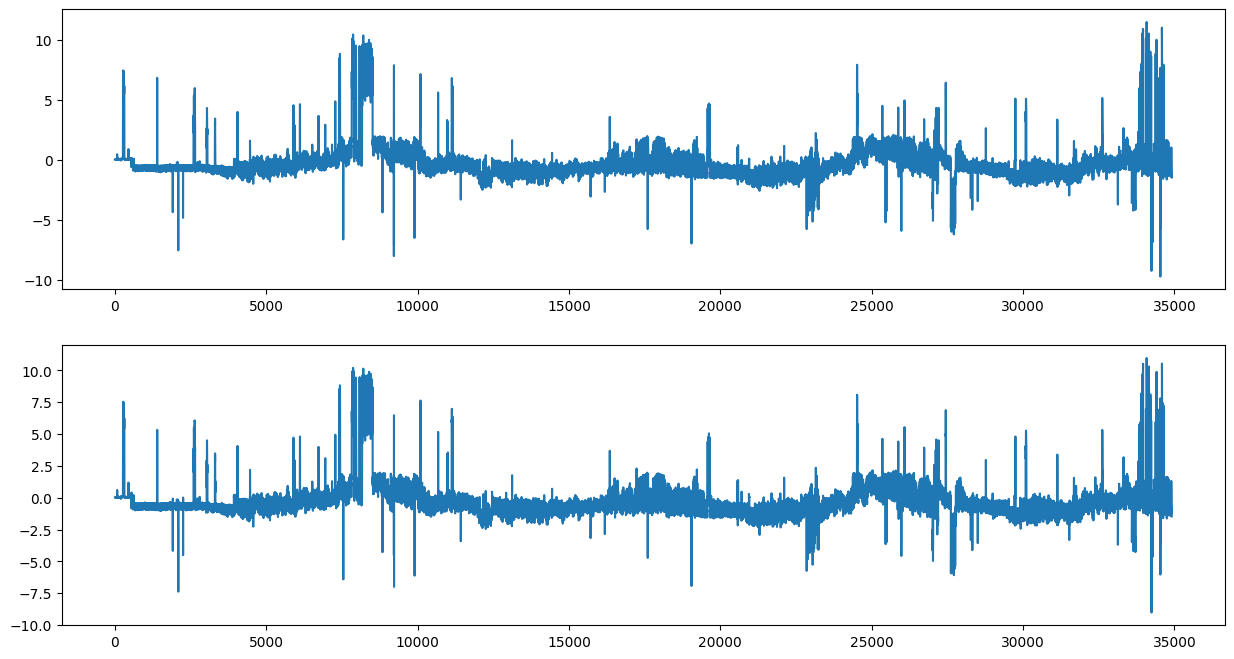

In [ ]:
# Realizar predicciones utilizando el modelo entrenado en los datos de entrada del conjunto de entrenamiento
yp = model.predict(yw)

# Crear una figura con dos subgráficos para visualizar los valores reales y las predicciones
fig, axes = plt.subplots(2, 1)

# Establecer el tamaño de la figura
fig.set_size_inches(15, 8)

# Graficar los valores reales del conjunto de salida (yt) en el primer subgráfico
axes[0].plot(yt)

# Graficar las predicciones del modelo (yp) en el segundo subgráfico
axes[1].plot(yp)

# Calcular la media de los valores reales del conjunto de salida
media = np.mean(yt)

# Calcular el error absoluto medio entre los valores reales y las predicciones del modelo
error = mean_absolute_error(yt, yp)

# Imprimir la media, el error absoluto medio y el error relativo al valor medio
print(media, error, error/media)


274/274 [==============================] - 2s 7ms/step
0.7504665209446107 0.1396671932030677 0.1861071604197198


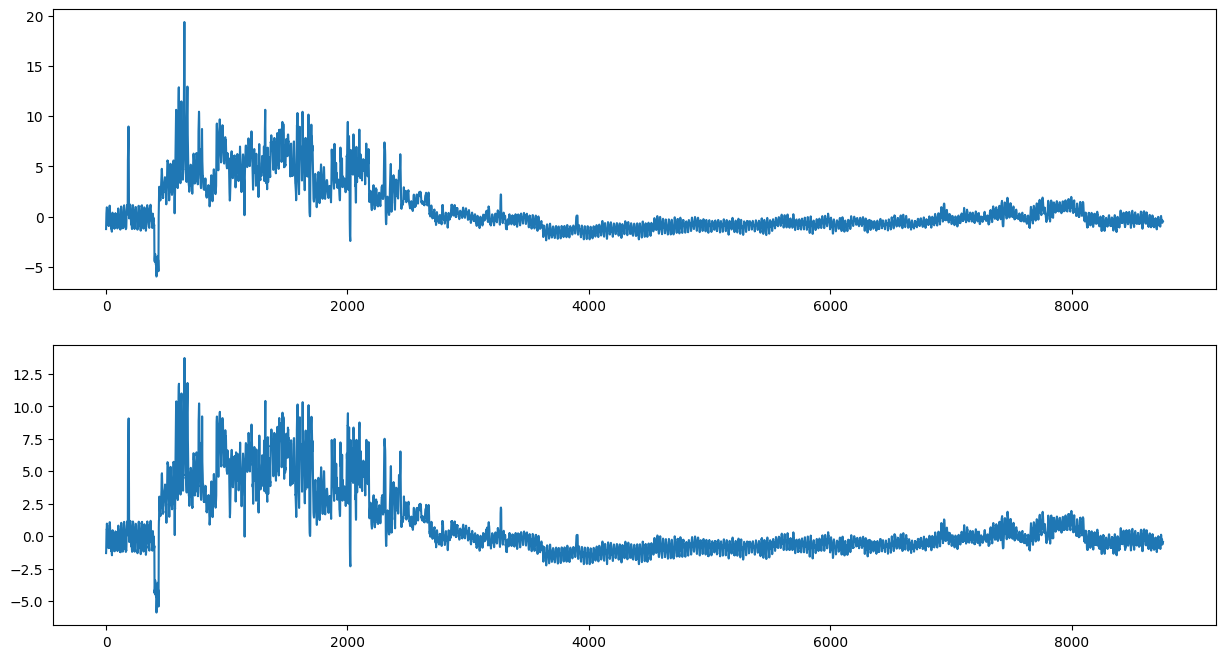

In [ ]:
# Realizar predicciones utilizando el modelo entrenado en los datos de entrada del conjunto de prueba
yp_test = model.predict(yw_test)

# Crear una figura con dos subgráficos para visualizar los valores reales y las predicciones del conjunto de prueba
fig, axes = plt.subplots(2, 1)

# Establecer el tamaño de la figura
fig.set_size_inches(15, 8)

# Graficar los valores reales del conjunto de salida del conjunto de prueba (yt_test) en el primer subgráfico
axes[0].plot(yt_test)

# Graficar las predicciones del modelo para el conjunto de prueba (yp_test) en el segundo subgráfico
axes[1].plot(yp_test)

# Calcular la media de los valores reales del conjunto de salida del conjunto de prueba
media = np.mean(yt_test)

# Calcular el error absoluto medio entre los valores reales y las predicciones del modelo para el conjunto de prueba
error = mean_absolute_error(yt_test, yp_test)

# Imprimir la media, el error absoluto medio y el error relativo al valor medio para el conjunto de prueba
print(media, error, error/media)


-0.34206974859012834 0.6638703917007838 -1.9407456942246022


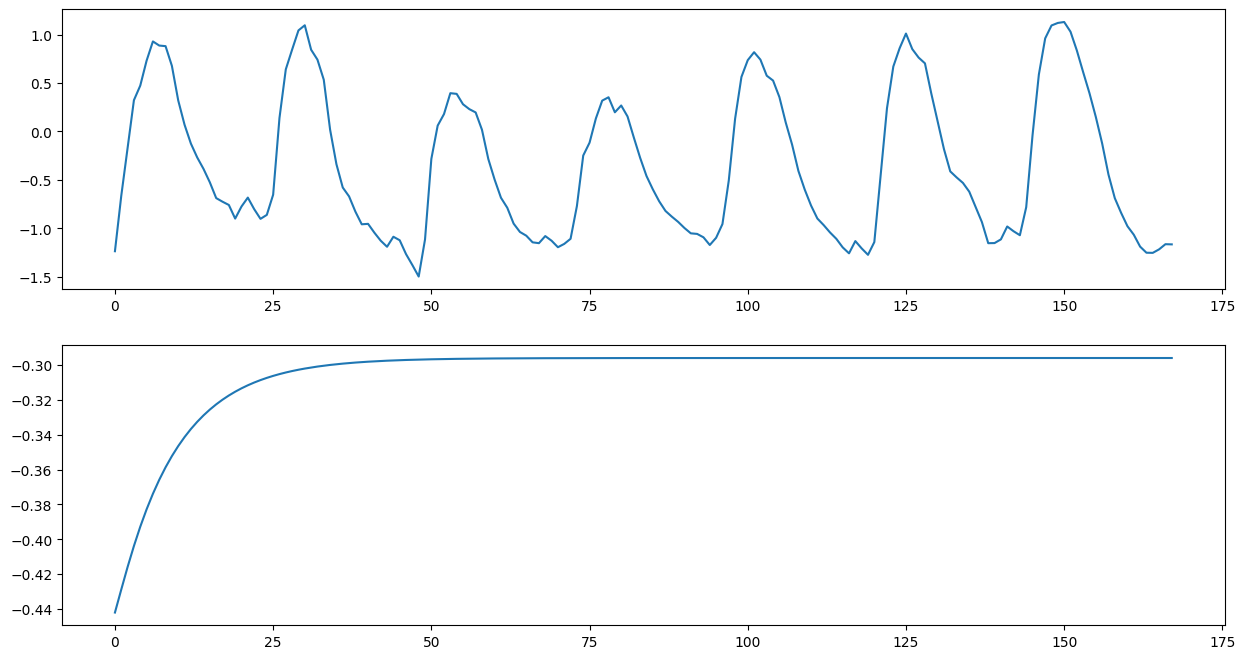

In [ ]:
# Crear una copia del último punto de datos del conjunto de prueba de entrada y darle la forma adecuada para realizar una predicción
ultimo = yw_test[-1].copy().reshape(1, 2, 1)

# Lista para almacenar las predicciones
forecasts = []

# Definir el horizonte de predicción en horas
horizonte = 7 * 24

# Iterar sobre el horizonte de predicción para predecir los valores futuros
for i in range(horizonte):
    # Realizar una predicción utilizando el modelo entrenado y el último punto de datos conocido
    forecast = model.predict(ultimo, verbose=0)

    # Obtener el valor de la predicción
    valor = forecast.reshape(1)[0]

    # Agregar el valor de la predicción a la lista de predicciones
    forecasts.append(valor)

    # Actualizar la lista de datos de entrada para la siguiente predicción eliminando el primer valor y agregando el valor predicho
    lista = ultimo.reshape(1, 2)[0].tolist()
    lista.pop(0)
    lista.append(valor)
    siguiente = np.asarray(lista).reshape(1, 2, 1)

    # Actualizar el último punto de datos conocido para la siguiente iteración
    ultimo = siguiente

# Crear una figura con dos subgráficos para visualizar los valores reales del conjunto de prueba y las predicciones
fig, axes = plt.subplots(2, 1)

# Establecer el tamaño de la figura
fig.set_size_inches(15, 8)

# Graficar los valores reales del conjunto de prueba en el primer subgráfico
axes[0].plot(yt_test[:horizonte])

# Graficar las predicciones en el segundo subgráfico
axes[1].plot(forecasts)

# Calcular la media de los valores reales del conjunto de prueba
media = np.mean(yt_test[:horizonte])

# Calcular el error absoluto medio entre los valores reales y las predicciones para el horizonte de predicción
error = mean_absolute_error(yt_test[:horizonte], forecasts)

# Imprimir la media, el error absoluto medio y el error relativo al valor medio para el horizonte de predicción
print(media, error, error/media)


In [ ]:
# Listas para almacenar las secuencias de datos de entrada (ventanas) y de salida (objetivos)
yw = []  # Datos de entrada (ventanas)
yt = []  # Datos de salida (objetivos)

# Tamaño de la ventana para crear las secuencias de entrada y salida
window = 216

# Iterar sobre los datos de entrenamiento para crear las secuencias
for i in range(0, len(ym)):
    # Verificar si todavía hay suficientes puntos de datos para crear una ventana completa
    if i + window < len(ym):
        # Lista para almacenar los datos de la ventana actual
        row = []
        # Iterar sobre los primeros 48 puntos de datos para los datos de entrada (ventanas)
        for j in range(48):
            # Agregar el punto de datos a la ventana de entrada
            row.append(ym[i + j])
        # Agregar la ventana completa al conjunto de datos de entrada (ventanas)
        yw.append(row)

        # Lista para almacenar los datos de la ventana actual
        row = []
        # Iterar sobre los siguientes 168 puntos de datos para los datos de salida (objetivos)
        for j in range(168):
            # Agregar el punto de datos al conjunto de datos de salida (objetivos)
            row.append(ym[i + 48 + j])
        # Agregar los objetivos al conjunto de datos de salida
        yt.append(row)
    else:
        # Si no quedan suficientes puntos de datos, salir del bucle
        break

# Imprimir la cantidad de ventanas creadas
print(len(yw))

# Convertir las listas de Python a arreglos NumPy
yw = np.asarray(yw)
yt = np.asarray(yt)


34701


In [ ]:
# Listas para almacenar las secuencias de datos de entrada (ventanas) y de salida (objetivos) del conjunto de prueba
yw_test = []  # Datos de entrada (ventanas)
yt_test = []  # Datos de salida (objetivos)

# Tamaño de la ventana para crear las secuencias de entrada y salida
window = 216

# Iterar sobre los datos de prueba para crear las secuencias
for i in range(0, len(ytm)):
    # Verificar si todavía hay suficientes puntos de datos para crear una ventana completa
    if i + window < len(ytm):
        # Lista para almacenar los datos de la ventana actual
        row = []
        # Iterar sobre los primeros 48 puntos de datos para los datos de entrada (ventanas)
        for j in range(48):
            # Agregar el punto de datos a la ventana de entrada
            row.append(ytm[i + j])
        # Agregar la ventana completa al conjunto de datos de entrada (ventanas)
        yw_test.append(row)

        # Lista para almacenar los datos de la ventana actual
        row = []
        # Iterar sobre los siguientes 168 puntos de datos para los datos de salida (objetivos)
        for j in range(168):
            # Agregar el punto de datos al conjunto de datos de salida (objetivos)
            row.append(ytm[i + 48 + j])
        # Agregar los objetivos al conjunto de datos de salida
        yt_test.append(row)
    else:
        # Si no quedan suficientes puntos de datos, salir del bucle
        break

# Imprimir la cantidad de ventanas creadas para el conjunto de prueba
print(len(yw_test))

# Convertir las listas de Python a arreglos NumPy para el conjunto de prueba
yw_test = np.asarray(yw_test)
yt_test = np.asarray(yt_test)


8544


In [ ]:
# Semilla utilizada para la generación de números aleatorios
seed = 12122008

# Fijar la semilla para la generación de números aleatorios de Python
rd.seed(seed)

# Fijar la semilla para la generación de números aleatorios de NumPy
np.random.seed(seed)

# Fijar la semilla para la generación de números aleatorios de TensorFlow
tf.random.set_seed(seed)

# Crear un modelo secuencial
model = Sequential()

# Añadir una capa de entrada al modelo, especificando el nombre y la forma de los datos de entrada
model.add(Input(name="serie", shape=(48, 1)))

# Añadir una capa LSTM con 256 unidades
model.add(LSTM(256))

# Añadir una capa densa con 256 unidades
model.add(Dense(256))

# Añadir una capa densa de salida con 168 unidades y activación lineal
model.add(Dense(168, activation='linear'))

# Generar una etiqueta única para el registro con el formato 'mrnnYYYYMMDD-HHMMSS' utilizando la fecha y hora actual
tag = "mrnn" + datetime.now().strftime("%Y%m%d-%H%M%S")

# Directorio de registro para TensorBoard que incluye la etiqueta única
log_dir = "logs/fit/" + tag

# Callback de TensorBoard para registrar la información del entrenamiento en el directorio especificado
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Definir el optimizador Adam con una tasa de aprendizaje de 0.0001 (1e-4)
optimizer = Adam(learning_rate=1e-4)

# Compilar el modelo con el optimizador Adam, la función de pérdida 'huber' y las métricas de 'mse' (mean squared error) y 'mae' (mean absolute error)
model.compile(optimizer=optimizer, loss='huber', metrics=['mse', 'mae'])

# Entrenar el modelo con los datos de entrada y salida del conjunto de entrenamiento, utilizando los datos de entrada y salida del conjunto de prueba para la validación
# Se utiliza un tamaño de lote de 256, 32 épocas de entrenamiento, mezclando los datos en cada época, y se muestra información detallada sobre el progreso del entrenamiento
# Se incluye el callback de TensorBoard para registrar los datos de entrenamiento en el directorio de registro
rnn = model.fit(yw, yt, validation_data=(yw_test, yt_test),
                batch_size=256, epochs=32, shuffle=True, verbose=1, callbacks=[tensorboard_callback])

# Guardar el modelo entrenado en el directorio de registro con un nombre que incluye la etiqueta única
model.save(log_dir + '/model_{0}.keras'.format(tag))


Epoch 1/32
136/136 [==============================] - 113s 815ms/step - loss: 0.3192 - mse: 1.4377 - mae: 0.5901 - val_loss: 0.6559 - val_mse: 3.1725 - val_mae: 0.9610
Epoch 2/32
136/136 [==============================] - 98s 723ms/step - loss: 0.2649 - mse: 1.2530 - mae: 0.5046 - val_loss: 0.5738 - val_mse: 2.6350 - val_mae: 0.8654
Epoch 3/32
136/136 [==============================] - 101s 741ms/step - loss: 0.2594 - mse: 1.2494 - mae: 0.4918 - val_loss: 0.9062 - val_mse: 5.1082 - val_mae: 1.2056
Epoch 4/32
136/136 [==============================] - 101s 746ms/step - loss: 0.2504 - mse: 1.2155 - mae: 0.4783 - val_loss: 1.0278 - val_mse: 6.3505 - val_mae: 1.3265
Epoch 5/32
136/136 [==============================] - 98s 722ms/step - loss: 0.2454 - mse: 1.2011 - mae: 0.4705 - val_loss: 0.8365 - val_mse: 4.7117 - val_mae: 1.1309
Epoch 6/32
136/136 [==============================] - 97s 715ms/step - loss: 0.2502 - mse: 1.2292 - mae: 0.4764 - val_loss: 0.7998 - val_mse: 4.3935 - val_mae: 1.

In [ ]:
# Obtener el último conjunto de datos de entrada del conjunto de prueba y darle la forma adecuada para realizar una predicción
ultimo = yw_test[-1].reshape(1, 48, 1)

# Imprimir la forma del conjunto de datos de entrada
print(ultimo.shape)


(1, 48, 1)

0.17979037848432444 0.9312103050731837 5.179422352427908 1.6621011677234112


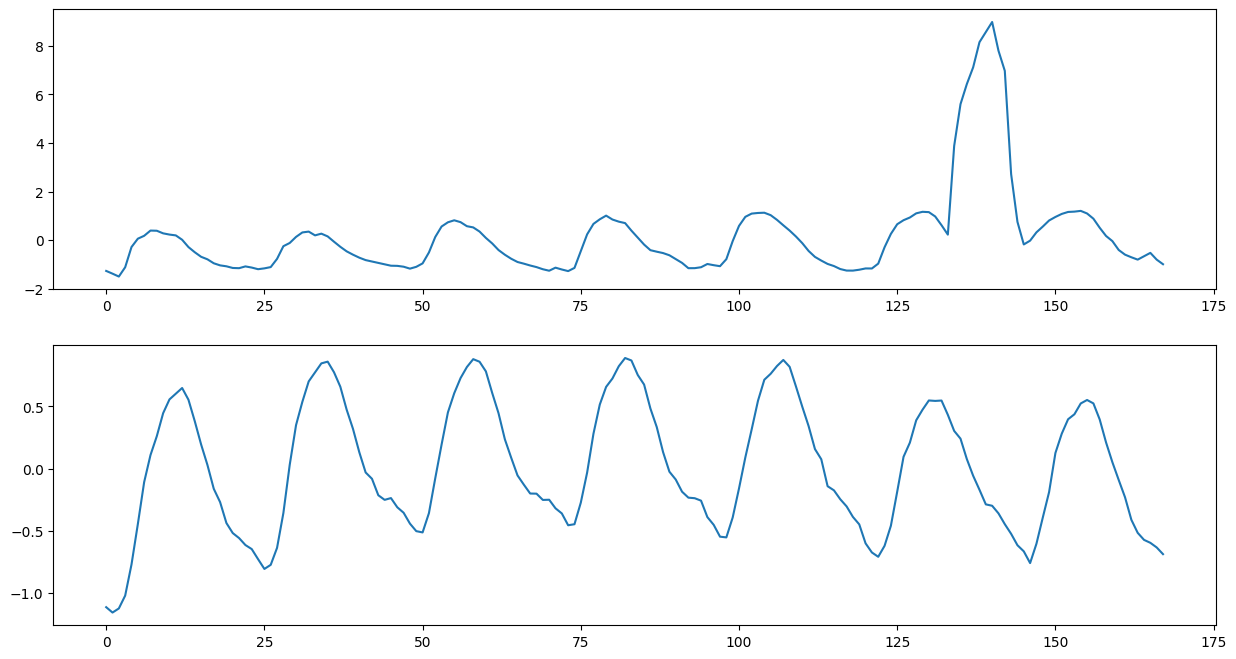

In [ ]:
# Importar la función mean_absolute_percentage_error del módulo metrics de sklearn
from sklearn.metrics import mean_absolute_percentage_error

# Realizar predicciones utilizando el modelo sobre el último conjunto de datos de entrada del conjunto de prueba
forecast = model.predict(ultimo, verbose=0)

# Crear una figura con dos subgráficos para visualizar los valores reales y las predicciones
fig, axes = plt.subplots(2, 1)

# Establecer el tamaño de la figura
fig.set_size_inches(15, 8)

# Convertir los valores reales del primer punto del conjunto de prueba en una lista
real = yt_test[0].tolist()

# Convertir las predicciones del primer punto del conjunto de prueba en una lista
pred = forecast[0].tolist()

# Graficar los valores reales en el primer subgráfico
axes[0].plot(real)

# Graficar las predicciones en el segundo subgráfico
axes[1].plot(pred)

# Calcular la media de los valores reales
media = np.mean(real)

# Calcular el error absoluto medio entre los valores reales y las predicciones
error = mean_absolute_error(real, pred)

# Calcular el error absoluto medio como porcentaje de la media de los valores reales
error2 = mean_absolute_percentage_error(real, pred)

# Imprimir la media, el error absoluto medio, el error relativo al valor medio y el error absoluto medio como porcentaje de la media
print(media, error, error/media, error2)
